In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
# PROJECT_ROOT_DIR = "."
# CHAPTER_ID = "rnn"

# def save_fig(fig_id, tight_layout=True):
#     path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
#     print("Saving figure", fig_id)
#     if tight_layout:
#         plt.tight_layout()
#     plt.savefig(path, format='png', dpi=300)

In [2]:
import tensorflow as tf

在本章中，我们将讨论循环神经网络RNN，它是一种可以预测未来的神经网络(至少是预测某些点)。它们可以分析时间序列数据，比如股票价格，然后告诉我们什么时候该买或该卖。在自动驾驶中，它们可以预测汽车的轨迹来帮我们避免事故。一般来说，它们可以工作在任意长度的序列上，而不是像我们目前为止讨论的所有网络那样的固定长度输入。例如，我们可以使用句子、文档、或者语言样本等作为输入，使其对于自然语言处理系统有用，比如自动翻译、语言转换文本，或者情感分析(例如阅读电影评论、提取评委对于电影的感受)等系统。

此外RNN的预测能力也使得它们能够产生惊人的创造力。你可以要求它们预测最优可能出现在旋律中的下一个音符是什么，然后随机选择一个音符并播放。

目前谷歌的Magenta项目就是生成音乐，类似地，RNN可以产出句子、图标等。

本章将介绍RNN的基本概念，面临的主要问题(也就是第11章讨论的消失/爆炸梯度问题)以及广泛用于LSTM和GRU单元的解决方案。与往常一样，我们将展示如何使用TensorFlow实现RNN。最后，我们会看一下机器翻译系统的架构。

本章，我会给大家介绍一下RNN，以及LSTM和GRU，以及如何做分类和生成，最后我会跳过NLP的部分。

# 循环神经元

到现在为止，我们主要关注前馈神经网络，其激活流只在一个方向上，从输入层到输出层。除了具有反向连接以外，循环神经网络与前馈神经网络非常相似。

In [3]:
reset_graph()

# 输入的特征数为3
n_inputs = 3
# 当前时间迭代输出的连接权重
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons],dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons,n_neurons],dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

# 第一个是接受x
Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
# 第二个除了接受x，还需要接受上一轮的输出
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
import numpy as np

# t=0 的输入
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
# t=1 的输入
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [5]:
# 第一轮的输出 t=0
print(Y0_val)

[[-0.06640061  0.9625767   0.6810579   0.7091854  -0.89821595]
 [ 0.99777555 -0.7197888  -0.99657613  0.96739244 -0.99989706]
 [ 0.99999785 -0.9989881  -0.99999887  0.9967763  -0.9999999 ]
 [ 1.         -1.         -1.         -0.9981892   0.9995087 ]]


In [6]:
# 第二轮的输出 t=1
print(Y1_val)

[[ 1.         -1.         -1.          0.40200272 -0.99999994]
 [-0.12210429  0.62805295  0.96718436 -0.9937122  -0.2583933 ]
 [ 0.99999815 -0.9999994  -0.99999744 -0.8594331  -0.99998796]
 [ 0.99928296 -0.9999981  -0.9999059   0.98579615 -0.9220575 ]]


## 记忆单元

循环神经元在时间迭代t的输出是之前时间迭代所有输入的函数，我们可以说这是一种形式的记忆。能够保存一些时间迭代的状态的神经网络称为记忆单元。

通常一个单元在时间迭代t的状态被记作$h_{(t)}$表示在某个时间迭代的输入和它在前一个时间迭代的状态的函数：$h_{(t)}=f(h_{(t-1)},x_{(t)})$.

## 输入和输出序列

RNN可以同时获取输入序列并产生输出序列，这种对于预测股票等时间序列是有用的：提供过去N天的价格，必须输出未来一天的价格。

或者，提供网络一系列输入，并且忽略除了最后一个之外的所有输出。换句话说，这是一个序列到向量网络。例如：输入给网络一个电影评论相关的单词序列，网络输出一个欢迎度评分。

相反，可以在第一个时间迭代给网络输入一个单词，并让它输出一个序列。这是一个向量到序列网络。例如，输入可以使一个图像，输出是该图像的标题。

最终，会有一个被称为编码器的序列到向量网络和一个被称为解码器的向量到序列网络。例如：语言翻译。

# TensorFlow中基本RNN

## 通过时间静态展开

In [7]:
n_inputs = 3
n_neurons = 5

In [8]:
reset_graph()

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.nn.static_rnn(basic_cell, [X0, X1],
                                       dtype=tf.float32)
Y0, Y1 = output_seqs

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API


当我们使用基本单元的时候，最终状态等于最后的输出

In [9]:
init = tf.global_variables_initializer()

In [10]:
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [11]:
Y0_val

array([[ 0.30741337, -0.32884312, -0.6542847 , -0.9385059 ,  0.52089024],
       [ 0.9912275 , -0.95425415, -0.7518078 , -0.9995208 ,  0.98202336],
       [ 0.99992675, -0.99783254, -0.82473516, -0.99999636,  0.99947786],
       [ 0.9967709 , -0.6875061 ,  0.8419969 ,  0.93039113,  0.81206834]],
      dtype=float32)

In [12]:
Y1_val

array([[ 0.99998885, -0.9997606 , -0.06679297, -0.9999803 ,  0.99982214],
       [-0.65249425, -0.5152086 , -0.37968948, -0.5922594 , -0.08968376],
       [ 0.998624  , -0.99715203, -0.03308632, -0.9991566 ,  0.9932902 ],
       [ 0.99681675, -0.9598194 ,  0.39660627, -0.8307605 ,  0.7967197 ]],
      dtype=float32)

### 当然这里还有问题，现在只有一个批量，如果有多个，那么显然上面的是不可取的

In [13]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [14]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
# 转换一下维度(序列，batch，n_inputs),即一个时间迭代一个张量列表
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2]))
basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.nn.static_rnn(basic_cell, X_seqs,
                                       dtype=tf.float32)
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

In [15]:
init = tf.global_variables_initializer()

In [21]:
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [17]:
print(outputs_val)

[[[-0.4565232  -0.6806412   0.40938237  0.631045   -0.45732823]
  [-0.94288003 -0.9998869   0.9405581   0.99999845 -0.99999976]]

 [[-0.80015343 -0.99218273  0.78177965  0.9971032  -0.9964609 ]
  [-0.637116    0.11300934  0.5798437   0.43105593 -0.6371699 ]]

 [[-0.93605185 -0.99983793  0.9308867   0.9999814  -0.99998313]
  [-0.9165386  -0.99456036  0.89605415  0.9998719  -0.9999751 ]]

 [[ 0.99273676 -0.9981933  -0.5554365   0.99890316 -0.9953323 ]
  [-0.02746333 -0.7319198   0.7827872   0.9525682  -0.9781772 ]]]


In [18]:
print(np.transpose(outputs_val, axes=[1, 0, 2])[1])

[[-0.94288003 -0.9998869   0.9405581   0.99999845 -0.99999976]
 [-0.637116    0.11300934  0.5798437   0.43105593 -0.6371699 ]
 [-0.9165386  -0.99456036  0.89605415  0.9998719  -0.9999751 ]
 [-0.02746333 -0.7319198   0.7827872   0.9525682  -0.9781772 ]]


在正向传播期间，为了能够计算反向传播时的梯度值，系统必须存储所有的张量值，所以如果使用这种大图像，系统很可能在数据反向传播期间内存溢出(OOM错误)，万幸，我们还有更好的解决方案。

## 通过时间动态展开

`dynamic_rnn()`函数使用`while_loop()`操作在单元上运行适当次。为了避免OOM错误，可以设置`swap_memory=True`来将GPU的内存换到CPU内存。方便的是，它可以对每个时间迭代的所有输出使用一个单独张量(shape[None,n_step,n_inputs]),并且对每个时间迭代的所有输出输出一个单独张量(shape[None,n_inputs,n_neurons])，不需要堆叠、拆分或者调换。

In [23]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [24]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


In [25]:
init = tf.global_variables_initializer()

In [26]:
# （批次，序列，维度）
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [27]:
print(outputs_val)

[[[-0.85115266  0.8735834   0.5802911   0.8954789  -0.0557505 ]
  [-0.99999595  0.9999957   0.9981816   1.          0.37679613]]

 [[-0.99832934  0.9992038   0.98071444  0.99998486  0.25192654]
  [-0.7081804  -0.07723369 -0.8522789   0.5845347  -0.7878094 ]]

 [[-0.9999826   0.9999953   0.99928635  1.          0.51590705]
  [-0.9993956   0.9984095   0.83422637  0.9999998  -0.47325197]]

 [[ 0.87888587  0.07356028  0.9721692   0.9998546  -0.7351168 ]
  [-0.9134514   0.3600957   0.7624865   0.99817705  0.80142   ]]]


## 处理长度可变输入序列

In [28]:
n_steps = 2
n_inputs = 3
n_neurons = 5

reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)

In [29]:
seq_length = tf.placeholder(tf.int32, [None])
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length)

Instructions for updating:
Use tf.cast instead.


In [30]:
init = tf.global_variables_initializer()

In [31]:
X_batch = np.array([
        # step 0     step 1
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2 (padded with zero vectors)
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])
seq_length_batch = np.array([2, 1, 2, 2]) # 第二十实例长度为1

In [32]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})

In [33]:
print(outputs_val)# 需要注意的是，第二个实例第二时间迭代的输出为0

[[[-0.91231877  0.16516447  0.5548655  -0.3915935   0.20846416]
  [-1.          0.95672596  0.9983169   0.9997017   0.96518576]]

 [[-0.99986124  0.67022896  0.9723652   0.66310453  0.74457586]
  [ 0.          0.          0.          0.          0.        ]]

 [[-0.99999976  0.89679974  0.9986295   0.96475154  0.93662006]
  [-0.99995255  0.96819544  0.9600286   0.9870626   0.8545923 ]]

 [[-0.9643544   0.9950159  -0.361507    0.99833775  0.99949706]
  [-0.9613586   0.9568762   0.71322876  0.9772921  -0.09582992]]]


In [34]:
print(states_val)

[[-1.          0.95672596  0.9983169   0.9997017   0.96518576]
 [-0.99986124  0.67022896  0.9723652   0.66310453  0.74457586]
 [-0.99995255  0.96819544  0.9600286   0.9870626   0.8545923 ]
 [-0.9613586   0.9568762   0.71322876  0.9772921  -0.09582992]]


## 处理长度可变输出序列

如果输出也是可变的话，可以通过结束令牌EOS token来忽略之后的输出。

# 训练RNN

训练RNN需要使用 通过时间反向传播(BPTT).类似于定期的反向传播，首先沿着展开网络的是一个正向传播；然后使用成本函数估算输出，成本函数的梯度是沿着展开的网络反向传播；最后，在BPTT期间使用梯度所计算的值更新网络参数。

## 训练序列分类器

下面让我们来训练一个MNIST的RNN网络。

In [35]:
reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])
# 每一个节点的输出权值为150个 ，
# 单层RNN结构为28个单元，
# 每个单元接收28的输入和150的前一层的结果
basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

Instructions for updating:
Use keras.layers.dense instead.


In [36]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [37]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [38]:
X_test = X_test.reshape((-1, n_steps, n_inputs))

In [39]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Last batch accuracy:", acc_batch, "Test accuracy:", acc_test)

0 Last batch accuracy: 0.9533333 Test accuracy: 0.9288
1 Last batch accuracy: 0.96 Test accuracy: 0.9471
2 Last batch accuracy: 0.96 Test accuracy: 0.9494
3 Last batch accuracy: 0.96666664 Test accuracy: 0.9552
4 Last batch accuracy: 0.96666664 Test accuracy: 0.9639
5 Last batch accuracy: 0.9266667 Test accuracy: 0.967
6 Last batch accuracy: 0.9866667 Test accuracy: 0.9635
7 Last batch accuracy: 0.97333336 Test accuracy: 0.9725
8 Last batch accuracy: 0.9866667 Test accuracy: 0.966
9 Last batch accuracy: 0.99333334 Test accuracy: 0.9635
10 Last batch accuracy: 0.98 Test accuracy: 0.9736
11 Last batch accuracy: 0.99333334 Test accuracy: 0.9747
12 Last batch accuracy: 0.96 Test accuracy: 0.969
13 Last batch accuracy: 0.97333336 Test accuracy: 0.9706
14 Last batch accuracy: 1.0 Test accuracy: 0.9796
15 Last batch accuracy: 0.97333336 Test accuracy: 0.9689
16 Last batch accuracy: 0.9866667 Test accuracy: 0.9754
17 Last batch accuracy: 0.99333334 Test accuracy: 0.9729
18 Last batch accuracy:

多层RNN网络

In [40]:
reset_graph()

n_steps = 28
n_inputs = 28
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

In [41]:
n_neurons = 100
n_layers = 3
# 两层网络，每一层输出都是100，激活函数使用relu
layers = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons,
                                      activation=tf.nn.relu)
          for layer in range(n_layers)]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.


In [42]:
states_concat = tf.concat(axis=1, values=states)
logits = tf.layers.dense(states_concat, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [43]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Last batch accuracy:", acc_batch, "Test accuracy:", acc_test)

0 Last batch accuracy: 0.91333336 Test accuracy: 0.9316
1 Last batch accuracy: 0.96 Test accuracy: 0.9587
2 Last batch accuracy: 0.97333336 Test accuracy: 0.969
3 Last batch accuracy: 0.9866667 Test accuracy: 0.972
4 Last batch accuracy: 0.97333336 Test accuracy: 0.9739
5 Last batch accuracy: 0.97333336 Test accuracy: 0.9752
6 Last batch accuracy: 0.99333334 Test accuracy: 0.9738
7 Last batch accuracy: 0.97333336 Test accuracy: 0.9764
8 Last batch accuracy: 1.0 Test accuracy: 0.9783
9 Last batch accuracy: 0.9866667 Test accuracy: 0.9694


## 训练预测时间序列

下面让我们来看看如何处理时间序列，比如股票、空气温度、脑波模式等等。在本节中，我们将训练一个RNN来预测生成时间序列力的下一个值。每个训练实例都是从时间序列中随机选择的20个连续值，除了时间迭代后移一个，目标序列和输入序列相同。

In [44]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

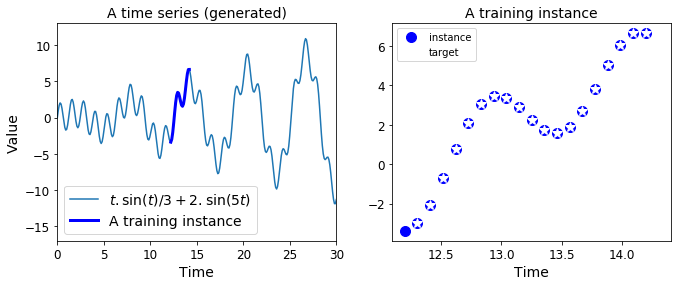

In [45]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

In [46]:
X_batch, y_batch = next_batch(1, n_steps)

In [47]:
np.c_[X_batch[0], y_batch[0]]

array([[ 1.38452097,  2.05081182],
       [ 2.05081182,  2.29742291],
       [ 2.29742291,  2.0465599 ],
       [ 2.0465599 ,  1.34009916],
       [ 1.34009916,  0.32948704],
       [ 0.32948704, -0.76115235],
       [-0.76115235, -1.68967022],
       [-1.68967022, -2.25492776],
       [-2.25492776, -2.34576159],
       [-2.34576159, -1.96789418],
       [-1.96789418, -1.24220428],
       [-1.24220428, -0.37478448],
       [-0.37478448,  0.39387907],
       [ 0.39387907,  0.84815766],
       [ 0.84815766,  0.85045064],
       [ 0.85045064,  0.3752526 ],
       [ 0.3752526 , -0.48422846],
       [-0.48422846, -1.53852738],
       [-1.53852738, -2.54795941],
       [-2.54795941, -3.28097239]])

现在在每个时间迭代中，我们会有一个大小100的输出向量，但是实际上我们只需要一个单独的输出值，最简单的解决方案为`OuputProjectionWrapper`。

In [48]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [49]:
# cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
# outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
# 对输出包装一个 OutputProjectionWrapper方法
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [50]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [51]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [52]:
saver = tf.train.Saver()

In [53]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    saver.save(sess, "./my_time_series_model") # not shown in the book

0 	MSE: 10.261382
100 	MSE: 0.387835
200 	MSE: 0.10971392
300 	MSE: 0.061384615
400 	MSE: 0.059246205
500 	MSE: 0.05795576
600 	MSE: 0.052708365
700 	MSE: 0.047345284
800 	MSE: 0.04890438
900 	MSE: 0.047190294
1000 	MSE: 0.04818168
1100 	MSE: 0.046514414
1200 	MSE: 0.0397035
1300 	MSE: 0.04625441
1400 	MSE: 0.04118413


In [54]:
with tf.Session() as sess:                          # not shown in the book
    saver.restore(sess, "./my_time_series_model")   # not shown

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./my_time_series_model


In [55]:
y_pred

array([[[-3.3995228 ],
        [-2.4585063 ],
        [-1.0623509 ],
        [ 0.72806376],
        [ 2.1840317 ],
        [ 3.1604254 ],
        [ 3.498221  ],
        [ 3.3751307 ],
        [ 2.8432434 ],
        [ 2.251946  ],
        [ 1.7014335 ],
        [ 1.5508372 ],
        [ 1.9195508 ],
        [ 2.7741208 ],
        [ 3.8722193 ],
        [ 5.1182957 ],
        [ 6.1199703 ],
        [ 6.676846  ],
        [ 6.7010484 ],
        [ 6.0852475 ]]], dtype=float32)

In [66]:
y_pred.shape

(1, 20, 1)

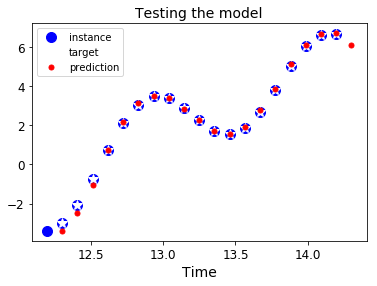

In [56]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

尽管这很简单，但是效率不高，下面不使用`OuputProjectionWrapper`

In [57]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [58]:
cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [59]:
n_outputs = 1
learning_rate = 0.001

In [60]:
# 规整输出(batch*n_step,n_neurons)
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
# 过 100->1 全连接层 (batch*n_step,1)
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
# 规整为 (batch,n_step,1)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

In [61]:
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [62]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    
    saver.save(sess, "./my_time_series_model")

0 	MSE: 13.907028
100 	MSE: 0.50593936
200 	MSE: 0.19500957
300 	MSE: 0.10084888
400 	MSE: 0.06752578
500 	MSE: 0.06240071
600 	MSE: 0.057652317
700 	MSE: 0.0510358
800 	MSE: 0.05072822
900 	MSE: 0.04841555
1000 	MSE: 0.048237946
1100 	MSE: 0.05023968
1200 	MSE: 0.04195461
1300 	MSE: 0.049693495
1400 	MSE: 0.044809423


In [64]:
y_pred

array([[[-3.433206  ],
        [-2.466031  ],
        [-1.1083548 ],
        [ 0.67640615],
        [ 2.0810804 ],
        [ 3.0872707 ],
        [ 3.5143006 ],
        [ 3.3971324 ],
        [ 2.8222928 ],
        [ 2.1863189 ],
        [ 1.6861348 ],
        [ 1.6197915 ],
        [ 1.9306939 ],
        [ 2.7211494 ],
        [ 3.844267  ],
        [ 5.114503  ],
        [ 6.146495  ],
        [ 6.702014  ],
        [ 6.6279254 ],
        [ 6.031665  ]]], dtype=float32)

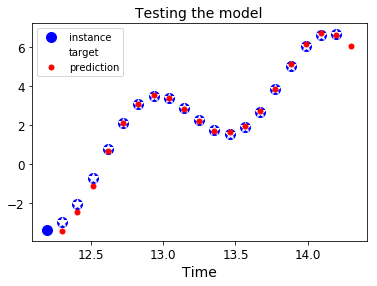

In [65]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

## 创造性的RNN

尽管已经有了一个可以预测未来的模型，像本章开始的那样，可以使用它来产生一些创造性的序列。我们需要做的事情是提供包含n_steps值的种子序列，并用模型预测下一个值，然后依次迭代。

In [67]:
with tf.Session() as sess:                        # not shown in the book
    saver.restore(sess, "./my_time_series_model") # not shown
    # 随机值
    sequence = [0.] * n_steps
    for iteration in range(300):
        # 获取每一轮要输入的数据，并做规整
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        # 将预测的y的最后一个值添加到序列最后
        sequence.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./my_time_series_model


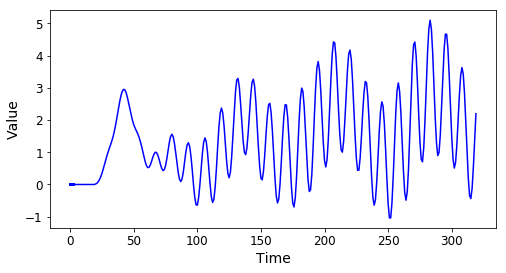

In [68]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

INFO:tensorflow:Restoring parameters from ./my_time_series_model


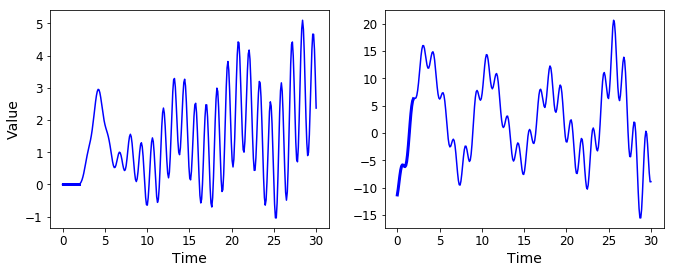

In [69]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")

    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.show()

# 深层RNN

在一个列表添加多个BasicRNNCell单元，然后通过MultiRNNCell来堆叠

In [75]:
reset_graph()

n_inputs = 2
n_steps = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

In [76]:
n_neurons = 100
n_layers = 3
# 3层 循环神经网络
layers = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
          for layer in range(n_layers)]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [77]:
init = tf.global_variables_initializer()

In [78]:
X_batch = np.random.rand(2, n_steps, n_inputs)

In [79]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch})

In [80]:
outputs_val.shape

(2, 5, 100)

## 在多个GPU中分配一个深层RNN

下面这种方法没有用

In [ ]:
with tf.device("/gpu:0"):  # BAD! This is ignored.
    layer1 = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)

with tf.device("/gpu:1"):  # BAD! Ignored again.
    layer2 = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)

In [82]:
import tensorflow as tf

class DeviceCellWrapper(tf.contrib.rnn.DeviceWrapper):
    def __init__(self, device, cell):
        self._cell = cell
        self._device = device

    @property
    def state_size(self):
        return self._cell.state_size

    @property
    def output_size(self):
        return self._cell.output_size

    def __call__(self, inputs, state, scope=None):
        with tf.device(self._device):
            return self._cell(inputs, state, scope)

In [83]:
reset_graph()

n_inputs = 5
n_steps = 20
n_neurons = 100

X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])

In [84]:
devices = ["/cpu:0", "/gpu:0", "/gpu:0"] # replace with ["/gpu:0", "/gpu:1", "/gpu:2"] if you have 3 GPUs
cells = [DeviceCellWrapper(dev,tf.contrib.rnn.BasicRNNCell(num_units=n_neurons))
         for dev in devices]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(cells)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [85]:
init = tf.global_variables_initializer()

In [86]:
with tf.Session() as sess:
    init.run()
    print(sess.run(outputs, feed_dict={X: np.random.rand(2, n_steps, n_inputs)}))

[[[-4.64021862e-02 -1.09517165e-01  1.15719415e-01 ... -2.52173096e-02
    1.18367799e-01  2.02370703e-01]
  [ 8.25042129e-02 -2.59060353e-01  1.70650661e-01 ...  1.27473608e-01
    2.67642349e-01  5.00117876e-02]
  [-4.02192652e-01 -5.05355418e-01  9.59849060e-02 ...  2.13280976e-01
    2.34671816e-01  4.09884632e-01]
  ...
  [-2.83994913e-01 -7.33134747e-01  3.17925781e-01 ...  3.41021657e-01
    4.12628025e-01 -6.32291138e-02]
  [ 2.27203444e-01 -7.05208540e-01  1.00495100e-01 ... -1.41650334e-01
    5.51967084e-01  5.99654056e-02]
  [-6.84822816e-03 -5.12680292e-01 -2.85935074e-01 ... -2.31354788e-01
    2.07134277e-01  8.85490924e-02]]

 [[-5.23373596e-02 -8.67693722e-02  8.17485750e-02 ... -1.00591511e-01
    1.27385452e-01  1.19344555e-01]
  [ 9.99870151e-02 -1.82395458e-01  2.22274549e-02 ...  1.32248014e-01
    2.45662972e-01  1.98397785e-04]
  [-3.53575349e-01 -4.52652514e-01  1.14802405e-01 ... -7.28873834e-02
    1.18325450e-01  2.53719836e-01]
  ...
  [-5.62218845e-01 -5.4

## 应用丢弃机制

In [87]:
reset_graph()

n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1

In [88]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [89]:
keep_prob = tf.placeholder_with_default(1.0, shape=())
cells = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
         for layer in range(n_layers)]
# 通过使用 input_keep_prob 超参数来定义丢弃率
cells_drop = [tf.nn.rnn_cell.DropoutWrapper(cell, input_keep_prob=keep_prob)
              for cell in cells]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(cells_drop)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [90]:
learning_rate = 0.01

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [91]:
n_iterations = 1500
batch_size = 50
train_keep_prob = 0.5

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        _, mse = sess.run([training_op, loss],
                          feed_dict={X: X_batch, y: y_batch,
                                     keep_prob: train_keep_prob})
        if iteration % 100 == 0:                   # not shown in the book
            print(iteration, "Training MSE:", mse) # not shown
    
    saver.save(sess, "./my_dropout_time_series_model")

0 Training MSE: 15.983469
100 Training MSE: 4.953362
200 Training MSE: 3.6653495
300 Training MSE: 3.6413739
400 Training MSE: 2.8444173
500 Training MSE: 3.4879916
600 Training MSE: 3.3014426
700 Training MSE: 3.4903915
800 Training MSE: 3.6474438
900 Training MSE: 3.761374
1000 Training MSE: 2.6914365
1100 Training MSE: 3.9620867
1200 Training MSE: 3.378571
1300 Training MSE: 3.4472103
1400 Training MSE: 4.2638426


In [92]:
with tf.Session() as sess:
    saver.restore(sess, "./my_dropout_time_series_model")

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_dropout_time_series_model


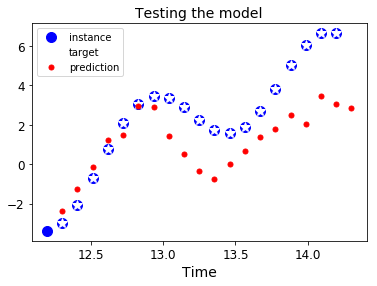

In [93]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

Oops, it seems that Dropout does not help at all in this particular case. :/

看起来，似乎 dropout并没有给我们的结果带来帮助

## 多个时间迭代训练的难点

为了训练一个长序列的RNN，将训练运行很多个时间迭代，使得展开的RNN称为一个非常深的网络。与其他深层神经网络一样，它可能遇到梯度消失/爆炸问题，并且无限的训练下去。我们之前讨论的用于缓解此问题的方法同样可以用于展开深层的RNN:良好的初始化参数、ReLU、批标准化、梯度裁剪、更快的优化器等。然而，如果RNN需要处理中等长度的序列，训练仍然会非常慢。

解决该问题最简单和普遍的方法是，训练期间只在有限的时间迭代上展开RNN网络。这种方法称为通过时间截断反向传播。当然，存在的问题是，模型无法学习长期模式。一个解决方法是保证这些缩短了的训练中同时包含新数据和旧数据。

初次之外，长期运行的RNN所面临的的第二个问题是第一个输入记忆逐渐衰退，也就是过一段时间后，RNN的状态已经丢失第一个输入的痕迹了。为了解决这个问题，我们引入了很多类型的长期记忆单元，使用最广泛的就是长期记忆单元LSTM。

# LSTM单元

LSTM训练 手写体识别

In [95]:
n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10
n_layers = 3

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])
# 3层 lstm单元 28个 输出为150
lstm_cells = [tf.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
multi_cell = tf.nn.rnn_cell.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
# 获取最后一层的 的h (layer,[c,h])
top_layer_h_state = states[-1][1]

logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

In [99]:
states[-1]

LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_8:0' shape=(?, 150) dtype=float32>)

In [97]:
top_layer_h_state

<tf.Tensor 'rnn/while/Exit_8:0' shape=(?, 150) dtype=float32>

In [98]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Last batch accuracy:", acc_batch, "Test accuracy:", acc_test)

0 Last batch accuracy: 0.97333336 Test accuracy: 0.9565
1 Last batch accuracy: 0.96 Test accuracy: 0.9707
2 Last batch accuracy: 0.96 Test accuracy: 0.9603
3 Last batch accuracy: 0.98 Test accuracy: 0.9799
4 Last batch accuracy: 0.97333336 Test accuracy: 0.9813
5 Last batch accuracy: 1.0 Test accuracy: 0.9818
6 Last batch accuracy: 0.9866667 Test accuracy: 0.9864
7 Last batch accuracy: 0.99333334 Test accuracy: 0.9856
8 Last batch accuracy: 1.0 Test accuracy: 0.9869
9 Last batch accuracy: 0.9866667 Test accuracy: 0.9854


## 窥视孔连接

LSTM中允许门限控制器看到长期状态c

In [103]:
reset_graph()
n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10
n_layers = 3

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])
# 3层 lstm单元 28个 输出为150
lstm_cells = [tf.nn.rnn_cell.LSTMCell(num_units=n_neurons,use_peepholes=True)
              for layer in range(n_layers)]
multi_cell = tf.nn.rnn_cell.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
# 获取最后一层的 的h (layer,[c,h])
top_layer_h_state = states[-1][1]

logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

In [104]:
states[-1]

LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_8:0' shape=(?, 150) dtype=float32>)

In [105]:
top_layer_h_state

<tf.Tensor 'rnn/while/Exit_8:0' shape=(?, 150) dtype=float32>

In [106]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Last batch accuracy:", acc_batch, "Test accuracy:", acc_test)

0 Last batch accuracy: 0.97333336 Test accuracy: 0.9514
1 Last batch accuracy: 0.9533333 Test accuracy: 0.9736
2 Last batch accuracy: 0.98 Test accuracy: 0.9705
3 Last batch accuracy: 1.0 Test accuracy: 0.9825
4 Last batch accuracy: 0.98 Test accuracy: 0.9839
5 Last batch accuracy: 0.99333334 Test accuracy: 0.9841
6 Last batch accuracy: 0.9866667 Test accuracy: 0.9852
7 Last batch accuracy: 1.0 Test accuracy: 0.9887
8 Last batch accuracy: 1.0 Test accuracy: 0.9882
9 Last batch accuracy: 1.0 Test accuracy: 0.9891


# GRU单元

对lstm的简化，合并两个状态向量c和h。

In [111]:
reset_graph()
n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10
n_layers = 3

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])
# 3层 lstm单元 28个 输出为150
lstm_cells = [tf.nn.rnn_cell.GRUCell(num_units=n_neurons)
              for layer in range(n_layers)]
multi_cell = tf.nn.rnn_cell.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
# 获取最后一层的 的h (layer)
top_layer_h_state = states[-1]

logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

In [112]:
states

(<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 150) dtype=float32>,
 <tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 150) dtype=float32>,
 <tf.Tensor 'rnn/while/Exit_5:0' shape=(?, 150) dtype=float32>)

In [113]:
top_layer_h_state

<tf.Tensor 'rnn/while/Exit_5:0' shape=(?, 150) dtype=float32>

In [114]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Last batch accuracy:", acc_batch, "Test accuracy:", acc_test)

0 Last batch accuracy: 0.97333336 Test accuracy: 0.9653
1 Last batch accuracy: 0.96666664 Test accuracy: 0.9771
2 Last batch accuracy: 0.98 Test accuracy: 0.9733
3 Last batch accuracy: 0.98 Test accuracy: 0.9801
4 Last batch accuracy: 0.99333334 Test accuracy: 0.9883
5 Last batch accuracy: 1.0 Test accuracy: 0.9879
6 Last batch accuracy: 0.99333334 Test accuracy: 0.9887
7 Last batch accuracy: 0.99333334 Test accuracy: 0.9885
8 Last batch accuracy: 1.0 Test accuracy: 0.9872
9 Last batch accuracy: 0.99333334 Test accuracy: 0.9895


LSTM和GRU是近年来RNN获得成功的一个主要原因，尤其在自然语言处理中的应用。

# 自然语言处理

大多数自然语言处理应用都是基于RNN的，诸如机器翻译、自动总结、语法分析、观点分析等。

## 单词嵌入

做一个word2vec

获取数据

In [125]:
from six.moves import urllib

import errno
import os
import zipfile

WORDS_PATH = "datasets/words"
WORDS_URL = 'http://mattmahoney.net/dc/text8.zip'

def mkdir_p(path):
    """Create directories, ok if they already exist.
    
    This is for python 2 support. In python >=3.2, simply use:
    >>> os.makedirs(path, exist_ok=True)
    """
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

def fetch_words_data(words_url=WORDS_URL, words_path=WORDS_PATH):
    os.makedirs(words_path, exist_ok=True)
    zip_path = os.path.join(words_path, "words.zip")
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(words_url, zip_path)
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    return data.decode("ascii").split()

In [126]:
words = fetch_words_data()

In [127]:
words[:5]

['anarchism', 'originated', 'as', 'a', 'term']

构建字典

In [128]:
from collections import Counter

vocabulary_size = 50000
# 安装词频的前500000个
vocabulary = [("UNK", None)] + Counter(words).most_common(vocabulary_size - 1)
vocabulary = np.array([word for word, _ in vocabulary])
dictionary = {word: code for code, word in enumerate(vocabulary)}
data = np.array([dictionary.get(word, 0) for word in words])

将词映射到字典

In [129]:
" ".join(words[:9]), data[:9]

('anarchism originated as a term of abuse first used',
 array([5234, 3081,   12,    6,  195,    2, 3134,   46,   59]))

In [130]:
" ".join([vocabulary[word_index] for word_index in [5241, 3081, 12, 6, 195, 2, 3134, 46, 59]])

'cycles originated as a term of abuse first used'

In [131]:
words[24], data[24]

('culottes', 0)

生成一个训练batch

In [132]:
from collections import deque

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=[batch_size], dtype=np.int32)
    labels = np.ndarray(shape=[batch_size, 1], dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = np.random.randint(0, span)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [133]:
np.random.seed(42)

In [134]:
data_index = 0
batch, labels = generate_batch(8, 2, 1)

In [135]:
batch, [vocabulary[word] for word in batch]

(array([3081, 3081,   12,   12,    6,    6,  195,  195]),
 ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term'])

In [136]:
labels, [vocabulary[word] for word in labels[:, 0]]

(array([[  12],
        [5234],
        [   6],
        [3081],
        [  12],
        [ 195],
        [   2],
        [   6]]),
 ['as', 'anarchism', 'a', 'originated', 'as', 'term', 'of', 'a'])

构建模型

In [137]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

learning_rate = 0.01

In [138]:
reset_graph()

# Input data.
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [139]:
vocabulary_size = 50000
embedding_size = 150

# Look up embeddings for inputs.
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

In [140]:
train_inputs = tf.placeholder(tf.int32, shape=[None])
# 做一个词向量的映射
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [141]:
# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

# Construct the Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# Add variable initializer.
init = tf.global_variables_initializer()

In [142]:
num_steps = 10001

with tf.Session() as session:
    init.run()

    average_loss = 0
    for step in range(num_steps):
        print("\rIteration: {}".format(step), end="\t")
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([training_op, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = vocabulary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = vocabulary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)

    final_embeddings = normalized_embeddings.eval()

Iteration: 0	Average loss at step  0 :  289.90948486328125
Nearest to over: tt, tuned, manichaeans, fractional, cambridge, balaguer, fluoride, strenuously,
Nearest to one: imagines, tijuana, hindrance, motorcyclist, steadfastly, lords, letting, hutchinson,
Nearest to were: bezier, antibodies, nicknamed, panthers, compiler, tao, smarter, busy,
Nearest to may: failure, rna, efficacious, aspirin, lecompton, definitive, geese, amphibious,
Nearest to two: annihilate, bettors, wir, cindy, epinephrine, team, voluntarily, crystallize,
Nearest to its: knob, abeokuta, bracelet, bastards, ivens, objectivity, blanton, cold,
Nearest to than: lame, watts, stones, sram, elves, zarqawi, applets, cloves,
Nearest to these: pedro, condoned, neck, ssn, supervising, doug, thereto, melton,
Nearest to they: lowly, deportation, shrewd, reznor, tojo, decadent, occured, risotto,
Nearest to is: interests, golfers, dropouts, egyptians, richards, legionnaires, opener, leonel,
Nearest to up: clair, drives, steadfas

In [143]:
np.save("./my_final_embeddings.npy", final_embeddings)

In [144]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

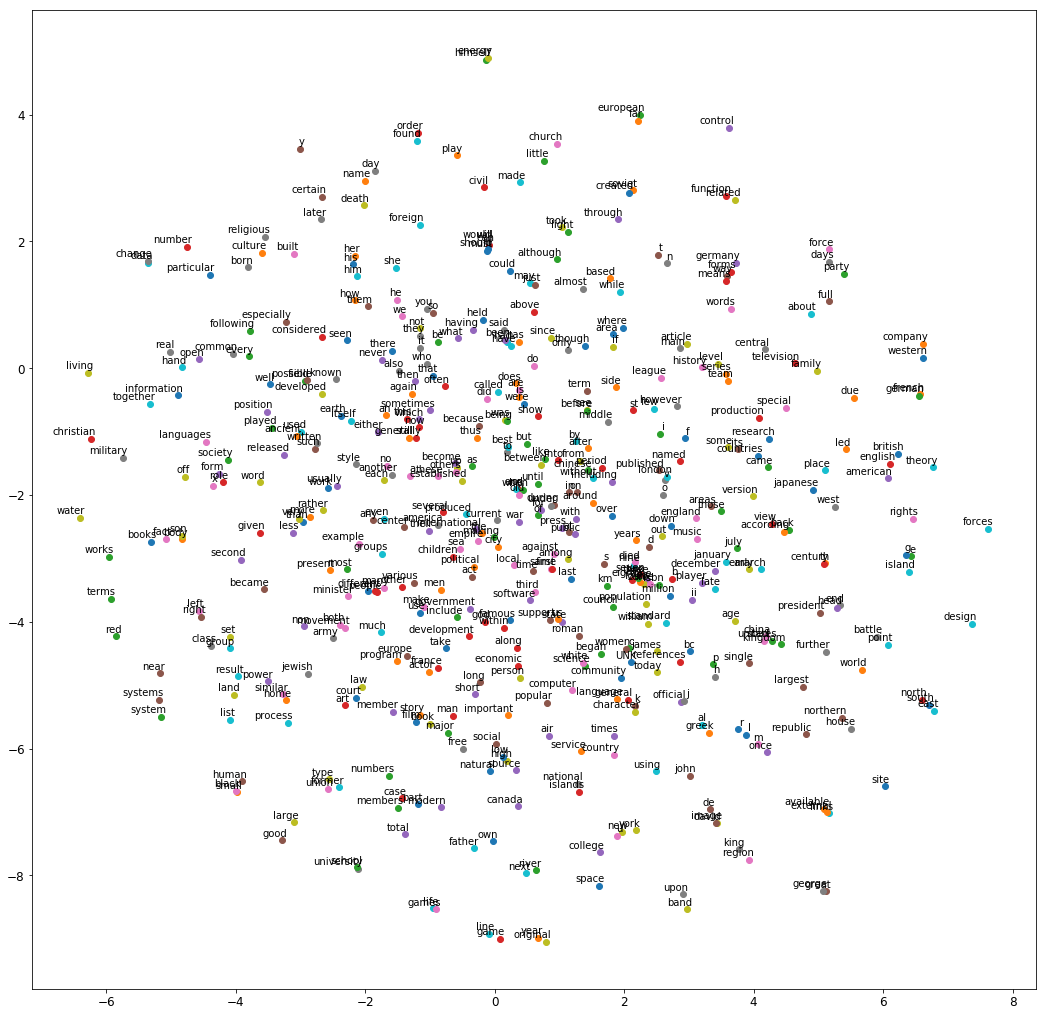

In [145]:
# 绘制500个单词词嵌入后的降维图
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocabulary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

## 用于机器翻译的编码器-解码器网络

In [146]:
import tensorflow as tf
reset_graph()

n_steps = 50
n_neurons = 200
n_layers = 3
num_encoder_symbols = 20000
num_decoder_symbols = 20000
embedding_size = 150
learning_rate = 0.01

X = tf.placeholder(tf.int32, [None, n_steps]) # English sentences
Y = tf.placeholder(tf.int32, [None, n_steps]) # French translations
W = tf.placeholder(tf.float32, [None, n_steps - 1, 1])
Y_input = Y[:, :-1]
Y_target = Y[:, 1:]

encoder_inputs = tf.unstack(tf.transpose(X)) # list of 1D tensors
decoder_inputs = tf.unstack(tf.transpose(Y_input)) # list of 1D tensors

lstm_cells = [tf.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
cell = tf.nn.rnn_cell.MultiRNNCell(lstm_cells)

output_seqs, states = tf.contrib.legacy_seq2seq.embedding_rnn_seq2seq(
    encoder_inputs,
    decoder_inputs,
    cell,
    num_encoder_symbols,
    num_decoder_symbols,
    embedding_size)

logits = tf.transpose(tf.unstack(output_seqs), perm=[1, 0, 2])

In [147]:
logits_flat = tf.reshape(logits, [-1, num_decoder_symbols])
Y_target_flat = tf.reshape(Y_target, [-1])
W_flat = tf.reshape(W, [-1])
xentropy = W_flat * tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y_target_flat, logits=logits_flat)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

# 练习

## 7.

生成指定语法的数据

In [148]:
np.random.seed(42)

default_reber_grammar = [
    [("B", 1)],           # (state 0) =B=>(state 1)
    [("T", 2), ("P", 3)], # (state 1) =T=>(state 2) or =P=>(state 3)
    [("S", 2), ("X", 4)], # (state 2) =S=>(state 2) or =X=>(state 4)
    [("T", 3), ("V", 5)], # and so on...
    [("X", 3), ("S", 6)],
    [("P", 4), ("V", 6)],
    [("E", None)]]        # (state 6) =E=>(terminal state)

embedded_reber_grammar = [
    [("B", 1)],
    [("T", 2), ("P", 3)],
    [(default_reber_grammar, 4)],
    [(default_reber_grammar, 5)],
    [("T", 6)],
    [("P", 6)],
    [("E", None)]]

def generate_string(grammar):
    state = 0
    output = []
    while state is not None:
        index = np.random.randint(len(grammar[state]))
        production, state = grammar[state][index]
        if isinstance(production, list):
            production = generate_string(grammar=production)
        output.append(production)
    return "".join(output)

生成默认的reber语法

In [149]:
for _ in range(25):
    print(generate_string(default_reber_grammar), end=" ")

BTXXTTVPXTVPXTTVPSE BPVPSE BTXSE BPVVE BPVVE BTSXSE BPTVPXTTTVVE BPVVE BTXSE BTXXVPSE BPTTTTTTTTVVE BTXSE BPVPSE BTXSE BPTVPSE BTXXTVPSE BPVVE BPVVE BPVVE BPTTVVE BPVVE BPVVE BTXXVVE BTXXVVE BTXXVPXVVE 

生成嵌入reber语法的语法

In [150]:
for _ in range(25):
    print(generate_string(embedded_reber_grammar), end=" ")

BTBPVVETE BTBTSSSSSSSXXVVETE BPBTSSSXXTTTTVPSEPE BTBPTTVVETE BPBTXXTVVEPE BTBTXSETE BPBTSSSSSXXTTVPXVPXTTTVVEPE BPBTSSXXTVPSEPE BPBPTTTTTTTVPSEPE BTBTSXSETE BPBPTVPXVVEPE BPBPVVEPE BPBPTVVEPE BTBPTTVPXTTVPSETE BTBTSSXSETE BTBTXXTTVVETE BPBTSXSEPE BPBPTVPSEPE BTBPVVETE BPBTXXTTTVPXTVVEPE BPBPTTVPXTVVEPE BTBPVVETE BPBPTVPXVPXTVVEPE BTBPVVETE BPBTSXSEPE 

生成篡改一部分原语法字符的语法

In [151]:
def generate_corrupted_string(grammar, chars="BEPSTVX"):
    # 每一个批次，改变任意位置的一个字符
    good_string = generate_string(grammar)
    index = np.random.randint(len(good_string))
    good_char = good_string[index]
    bad_char = np.random.choice(sorted(set(chars) - set(good_char)))
    return good_string[:index] + bad_char + good_string[index + 1:]

In [152]:
for _ in range(25):
    print(generate_corrupted_string(embedded_reber_grammar), end=" ")

BTTTXXVVETE BPBTXXSPXTVVEPE BTBTXSPTE BPTTSXXTVPXVVEPE PPBPVPSEPE BTBPTVETE BPTTSSSSSXSEPE BPBSVPSEPE BTBPVVESE BPBTXSEPS BEBTXSETE XPBTXXTVPSEPE BTBPVVEPE BTXPTVVETE BTBPVXETE BVBTXSETE BPTTXXVPXVPSEPE BTBPXVPSETE STBPTTVPXVPXTVPSETE BPBPTVPSESE BPBPVEEPE ETBTXSETE BTBTXSVTE BPBTXXVPSEPP BTBTXXVPSETS 

转为one-hot

In [153]:
def string_to_one_hot_vectors(string, n_steps, chars="BEPSTVX"):
    char_to_index = {char: index for index, char in enumerate(chars)}
    output = np.zeros((n_steps, len(chars)), dtype=np.int32)
    for index, char in enumerate(string):
        output[index, char_to_index[char]] = 1.
    return output

In [154]:
string_to_one_hot_vectors("BTBTXSETE", 12)

array([[1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

生成数据集

In [155]:
def generate_dataset(size):
    # 两个数据集
    good_strings = [generate_string(embedded_reber_grammar)
                    for _ in range(size // 2)]
    bad_strings = [generate_corrupted_string(embedded_reber_grammar)
                   for _ in range(size - size // 2)]
    all_strings = good_strings + bad_strings
    n_steps = max([len(string) for string in all_strings])
    X = np.array([string_to_one_hot_vectors(string, n_steps)
                  for string in all_strings])
    # 计算一下长度
    seq_length = np.array([len(string) for string in all_strings])
    y = np.array([[1] for _ in range(len(good_strings))] +
                 [[0] for _ in range(len(bad_strings))])
    rnd_idx = np.random.permutation(size)
    return X[rnd_idx], seq_length[rnd_idx], y[rnd_idx]

In [156]:
X_train, l_train, y_train = generate_dataset(10000)

In [157]:
X_train[0]

array([[1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0,

In [158]:
l_train[0]

23

In [159]:
y_train[0]

array([0])

定义计算图

In [160]:
reset_graph()

possible_chars = "BEPSTVX"
n_inputs = len(possible_chars)
n_neurons = 30
n_outputs = 1

learning_rate = 0.02
momentum = 0.95

X = tf.placeholder(tf.float32, [None, None, n_inputs], name="X")
seq_length = tf.placeholder(tf.int32, [None], name="seq_length")
y = tf.placeholder(tf.float32, [None, 1], name="y")
# 使用gru，传入 X，和X的长度
gru_cell = tf.nn.rnn_cell.GRUCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(gru_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length)
# 对30个输出过全连接
logits = tf.layers.dense(states, n_outputs, name="logits")
y_pred = tf.cast(tf.greater(logits, 0.), tf.float32, name="y_pred")
# 走sigmoid
y_proba = tf.nn.sigmoid(logits, name="y_proba")

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=momentum,
                                       use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.equal(y_pred, y, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [161]:
X_val, l_val, y_val = generate_dataset(5000)

开始训练

In [162]:
n_epochs = 50
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        X_batches = np.array_split(X_train, len(X_train) // batch_size)
        l_batches = np.array_split(l_train, len(l_train) // batch_size)
        y_batches = np.array_split(y_train, len(y_train) // batch_size)
        for X_batch, l_batch, y_batch in zip(X_batches, l_batches, y_batches):
            loss_val, _ = sess.run(
                [loss, training_op],
                feed_dict={X: X_batch, seq_length: l_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, seq_length: l_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_val, seq_length: l_val, y: y_val})
        print("{:4d}  Train loss: {:.4f}, accuracy: {:.2f}%  Validation accuracy: {:.2f}%".format(
            epoch, loss_val, 100 * acc_train, 100 * acc_val))
        saver.save(sess, "./my_reber_classifier")

   0  Train loss: 0.6727, accuracy: 66.00%  Validation accuracy: 59.34%
   1  Train loss: 0.6553, accuracy: 68.00%  Validation accuracy: 61.82%
   2  Train loss: 0.6200, accuracy: 76.00%  Validation accuracy: 72.50%
   3  Train loss: 0.4908, accuracy: 82.00%  Validation accuracy: 73.22%
   4  Train loss: 0.6419, accuracy: 74.00%  Validation accuracy: 62.46%
   5  Train loss: 0.5888, accuracy: 74.00%  Validation accuracy: 70.90%
   6  Train loss: 0.5996, accuracy: 72.00%  Validation accuracy: 69.86%
   7  Train loss: 0.4777, accuracy: 80.00%  Validation accuracy: 78.44%
   8  Train loss: 0.2762, accuracy: 90.00%  Validation accuracy: 90.64%
   9  Train loss: 0.0512, accuracy: 100.00%  Validation accuracy: 96.94%
  10  Train loss: 0.0161, accuracy: 100.00%  Validation accuracy: 97.90%
  11  Train loss: 0.0209, accuracy: 100.00%  Validation accuracy: 98.04%
  12  Train loss: 0.0234, accuracy: 100.00%  Validation accuracy: 98.20%
  13  Train loss: 0.0077, accuracy: 100.00%  Validation accu

验证一下

In [163]:
test_strings = [
    "BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE",
    "BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE"]
l_test = np.array([len(s) for s in test_strings])
max_length = l_test.max()
X_test = [string_to_one_hot_vectors(s, n_steps=max_length)
          for s in test_strings]

with tf.Session() as sess:
    saver.restore(sess, "./my_reber_classifier")
    y_proba_val = y_proba.eval(feed_dict={X: X_test, seq_length: l_test})

print()
print("Estimated probability that these are Reber strings:")
for index, string in enumerate(test_strings):
    print("{}: {:.2f}%".format(string, 100 * y_proba_val[index][0]))

INFO:tensorflow:Restoring parameters from ./my_reber_classifier

Estimated probability that these are Reber strings:
BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE: 2.63%
BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE: 98.10%
